# Practicals for lecture 1.4

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vigji/python-cimec-2024/blob/main/practicals/Practicals_1.4.ipynb)

#### 1.4.0 Organize a dataframe

In [20]:
import numpy as np
import pandas as pd


# Let's have a look into how to organize data in a dataframe.

# Use the following function that generates results for many subjects on
# an experiment with experimental trials of different difficulty levels.

def get_experiment_block_data(n_subjects=50, difficulty_levels=(1, 2, 3, 4, 5), n_repetitions=50):
    """Generate a dataframe with results from an experiment with experimental blocks.

    Parameters
    ----------
    n_reps : int
        Number of experimental blocks.
    n_subjects : int
        Number of subjects.
    difficulty_levels : tuple
        Difficulty levels of the experimental blocks.

    Returns
    -------
    dict
        A dictionary with the results of the experiment for each subject.


    """


    np.random.seed(42)
    subject_dict = dict()
    for subject in range(n_subjects):
        subject_ability = np.random.randint(1, 6)
        difficulty_level_arr = np.random.choice(difficulty_levels, size=n_repetitions)
        rt = np.random.normal(1000, 100, size=n_repetitions) * difficulty_level_arr / subject_ability
        error = np.random.uniform(0, 1000*difficulty_level_arr / subject_ability, size=n_repetitions)

        subject_dict[f"subject_{subject}"] = dict(
            difficulty_level=difficulty_level_arr,
            rt=rt,
            error=error,
        )

    return subject_dict


# Run the function to generate the data dictionary.
data = get_experiment_block_data()

# Data is a dictionary with an entry for every subject. Have a look!
# Each entry is itself a list, with the trial by trial data
# on task difficulty, rection times, and trial error.
data

[    difficulty_level           rt        error subject_id
 0                  5  1122.305976   944.438923  subject_0
 1                  3   737.868346   171.598624  subject_0
 2                  5  1183.293900    96.224887  subject_0
 3                  5  1249.309017   362.189316  subject_0
 4                  2   488.527477    80.610644  subject_0
 5                  3   779.201168   697.273239  subject_0
 6                  3   655.116066   606.090285  subject_0
 7                  3   831.899420   475.052817  subject_0
 8                  5  1597.289130  1089.325738  subject_0
 9                  4  1119.363972   803.672077  subject_0
 10                 3   766.397874   139.927544  subject_0
 11                 5  1360.220130  1115.698748  subject_0
 12                 2   449.545733   269.671121  subject_0
 13                 4   841.670579   807.440155  subject_0
 14                 2   538.685021   448.045650  subject_0
 15                 4   946.185834   318.003475  subject

In [24]:
# Convert this nested data to a (flat) dataframe containing all data.
# (Hint: you can create a DataFrame for every subject and then concatenate) 
all_trials_df_list = []
for key in data.keys():
    df = pd.DataFrame(data[key])
    df["subject_id"] = key
    all_trials_df_list.append(df)
    
all_trials_df = pd.concat(all_trials_df_list)

<Axes: xlabel='difficulty_level', ylabel='rt'>

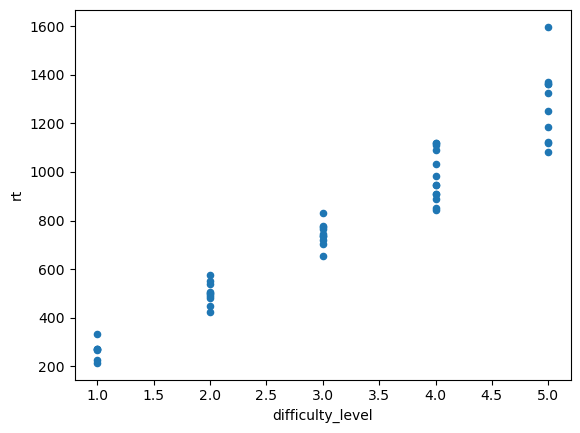

In [26]:
# Select the data for subject 0, and create a scatter plot 
# with the reaction time as a function of the trial difficulty level
# (Hint: remember the dataframe.plot() function from last lecture)

all_trials_df.loc[all_trials_df["subject_id"] == "subject_0", :].plot(kind="scatter", 
                                                                      x="difficulty_level",
                                                                      y="rt")


In [28]:
# Load the subjects dataframe from the csv file at the url:
# https://raw.githubusercontent.com/vigji/python-cimec/main/practicals/data/subjects_df.csv

subject_df = pd.read_csv("https://raw.githubusercontent.com/vigji/python-cimec/main/practicals/data/subjects_df.csv",
                         index_col=0)
subject_df.head()

,sex,handedness,age
subject_0,F,left,37
subject_1,M,right,31
subject_2,F,left,21
subject_3,F,right,29
subject_4,F,left,23


<Axes: xlabel='difficulty_level', ylabel='rt'>

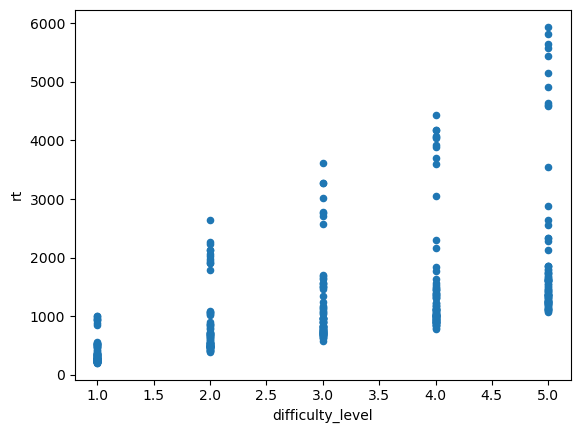

In [38]:
# Now use boolean indexing on the subject dataframe to include only left-handed males 
# above 30 years in the analysis.
# Plot the reaction time as a function of the trial difficulty 
# level for this subpopulation only:

selection = (subject_df["handedness"] == "left") & (subject_df["age"] > 30)
filtered_subject_df = subject_df[selection]


trial_selection = all_trials_df["subject_id"].isin(filtered_subject_df.index)

all_trials_df[trial_selection].plot(kind="scatter", x="difficulty_level", y="rt")

In [1]:
# [Advanced]
# The Allen Brain Observatory dataset (https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)
# contains electrophysiology data (single neuron activity) from hundreds of
# recording sessions in the visual cortex of mice.

# Here you find some of their data:

# - a neuron_csv with information about individual neurons from all electrodes from all sessions
#   Each neuron has a channel_id column that specifies which electrode it was recorded from
#   link: https://github.com/vigji/python-cimec-2024/raw/main/practicals/data/allen_neurons.csv

# - A channel_csv with information about individual electrodes from all sessions.
#   Each channel has a session_id that specifies from which session it was recorded
#   and a ecephys_structure_acronym column with the acronym of the brain area
#   where the electrode was:
#   link: https://github.com/vigji/python-cimec-2024/raw/main/practicals/data/allen_channels.csv

# - A session_csv with information about all sessions and the animal that was recorded 
#   in that session.
#   link: https://github.com/vigji/python-cimec-2024/raw/main/practicals/data/allen_sessions.csv 

# Use the read_csv function to read data from the links!

In [8]:
# Select only neurons that were recorded in animals of wild type genotype (wt/wt)
# and have a valid entry in the g_dsi_dg (their direction selectivity index)


#### 1.4.1  `.groupby()` and index broadcasting

In [52]:
# Take the meteo dataset using the function below
def get_meteo_dataset():
    """Get a meteo dataset from the open-meteo API using a fixed window.
    Note how easy it is to get data from the web with pandas! As long as we give the URL of the csv data, pandas can read it.
    """
    np.random.seed(42)
    # URL = "https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41&current=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m,winddirection_10m&start_date=2023-02-10&end_date=2023-05-28&format=csv"
    URL = "https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,winddirection_10m&start_date=2024-04-01&end_date=2024-04-20&format=csv"
    df = pd.read_csv(URL, skiprows=6)  # read the csv file, skipping the first 3 rows (a header)
    df.columns = [col.split(" ")[0] for col in df.columns]  # simplify column names
    df["time"] = pd.to_datetime(df["time"])  # convert the time column to datetime
    df["hour"], df["dayofyear"] = df["time"].dt.hour, df["time"].dt.dayofyear  # extract the hour and day of year

    # Here we artificially corrupt some of the data:
    missing_idx = np.random.choice(df.index[:1000], 100)
    df.loc[missing_idx, :] = np.nan
    return df

# This new meteo dataset has columns for the day of the year, 
# hour of the day, and day of the week.
# Check out the data and make sure we don't have missing values!
ds = get_meteo_dataset()
ds = ds.interpolate()
ds

,time,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,winddirection_10m,hour,dayofyear
0,2024-04-01 00:00:00,10.200,97.00,0.0,4.10,38.0,0.0,92.0
1,2024-04-01 01:00:00,9.900,96.00,0.0,4.05,59.0,1.0,92.0
2,2024-04-01 02:00:00,9.600,95.00,0.0,4.00,80.0,2.0,92.0
3,2024-04-01 03:00:00,9.200,95.00,0.0,5.40,82.0,3.0,92.0
4,2024-04-01 04:00:00,9.400,94.00,0.0,7.40,67.0,4.0,92.0
...,...,...,...,...,...,...,...,...
475,2024-04-20 19:00:00,5.350,64.50,0.0,8.50,58.0,19.0,111.0
476,2024-04-20 20:00:00,4.475,68.75,0.0,6.95,74.0,20.0,111.0
477,2024-04-20 21:00:00,3.600,73.00,0.0,5.40,90.0,21.0,111.0
478,2024-04-20 22:00:00,2.900,79.00,0.0,5.20,106.0,22.0,111.0


In [50]:
# Use the .groupby() method to compute the mean temperature for each hour of the day:
mean_temps = ds.groupby("dayofyear").mean()["temperature_2m"]
mean_temps

dayofyear
92.000000     13.110417
93.000000     11.270833
93.250000      9.775000
93.500000      9.750000
93.750000      9.725000
94.000000     10.352500
94.500000     10.150000
95.000000     11.708333
96.000000     14.325000
97.000000     17.210417
98.000000     18.818750
99.000000     20.273684
99.166667     22.516667
99.333333     21.333333
99.500000     20.150000
99.666667     18.966667
99.833333     17.783333
100.000000    17.858333
101.000000    11.987500
102.000000    12.367391
102.333333    13.100000
102.666667    13.000000
103.000000    15.963043
104.000000    17.547917
105.000000    14.806250
106.000000    10.643478
106.500000     6.900000
107.000000     7.000000
108.000000     6.264583
109.000000     6.858333
110.000000     6.529167
111.000000     5.735417
Name: temperature_2m, dtype: float64

<Axes: >

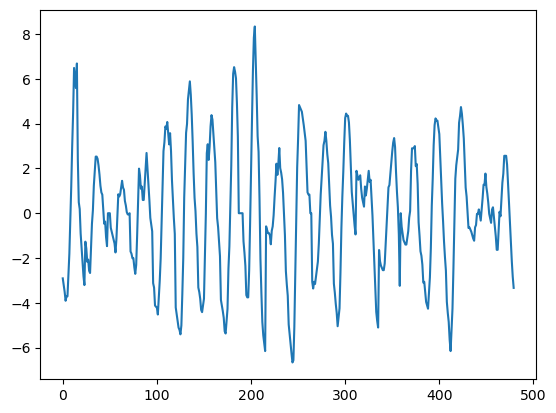

In [66]:
# Using pandas index broadcasting, subtract from each day of the year 
# its average temperature, and plot the result to check if it makes sense.
# (Hint: you will have to set a new index to the dataframe 
# for the broadcasting to work):
from matplotlib import pyplot as plt
temperature_normalized = ds.set_index("dayofyear")["temperature_2m"] - mean_temps

temperature_normalized.reset_index()["temperature_2m"].plot()
#plt.plot(ds["temperature_2m"].values)
# plt.plot(temperature_normalized.values)

In [63]:
temperature_normalized

dayofyear
92.0    -2.910417
92.0    -3.210417
92.0    -3.510417
92.0    -3.910417
92.0    -3.710417
           ...   
111.0   -0.385417
111.0   -1.260417
111.0   -2.135417
111.0   -2.835417
111.0   -3.335417
Name: temperature_2m, Length: 480, dtype: float64

In [ ]:
# [Advanced]

# From the Allen datasets you have loaded above, produce a new dataframe 
# that for every brain area has a column with the average firing rate
# and a column with the average direction selectivity index for that area.

# Sort the areas by average DSI; do the first acronyms that you see
# make sense? (to find the meanings of the acronyms, you can read the
# structures csv file at 
# https://github.com/vigji/python-cimec-2024/raw/main/practicals/data/allen_structures.csv 


In [ ]:
# [Advanced]

# Now, let's make a new column "Z-scored firing rate" where, for every neuron,
# we add the firing rate z-scored within each brain area.
# Compute mean and std of firing rate for every area, and compute the Z-score
# for every neuron using the mean and std for the brain area it belongs to!
# (no for loops of course)

#### 1.4.2 `.rolling()`

In [5]:
# Compute the maximum and the minimum of the temperature using a rolling window of 24 samples.
# Plot the original curve and the smoothed one to check what you did:

